Original storm types
storm_types = {
    #"Tornado": "torn",
    #"Thunderstorm Wind": "wind", 
    #"Strong Wind": "wind",
    #"High Wind": "wind",
    "Hail": "hail"
}


# Calculate PPH for hail

In [34]:
"""
Generate PPH for annual NCEI_storm_reports
1200z Day1 to 1200z Day2 time windows
File names use Day1
    
MODIFIED: Now creates files with all zeros for dates with no events
MODIFIED: Accounts for BEGIN_DATE_TIME and END_DATE_TIME with 1200z-1200z periods
"""

import numpy as np
import os
import pandas as pd
import xarray as xr
import calendar
from datetime import datetime, timedelta

sigma_grid_units = 1.5
grid_spacing_km = 40.0   

# Download and Load NAM-212 grid 
url = 'https://github.com/ahaberlie/PPer_Climo/tree/master/data'
try:
    grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
    grid212_lat = grid_ds["gridlat_212"].values  # (ny, nx)
    grid212_lon = grid_ds["gridlon_212"].values  # (ny, nx)
    print(f"Loaded grid with shape: {grid212_lat.shape}")
except Exception as e:
    print(f"Error loading grid file: {e}")
    exit(1)

# Storm type mapping from EVENT_TYPE
storm_types = {
    "Hail": "hail"
}

# Distance function for PPH
def euclidean_distance_km(grid_lat, grid_lon, report_lat, report_lon):
    lat_km = 111.32 * (grid_lat - report_lat)
    lon_km = 111.32 * np.cos(np.radians(report_lat)) * (grid_lon - report_lon)
    return np.sqrt(lat_km**2 + lon_km**2)

def parse_datetime_string(dt_string):
    """Parse datetime string to datetime object"""
    if pd.isna(dt_string) or dt_string == '' or dt_string is None:
        return None
    
    try:
        formats = [
            '%d-%b-%y %H:%M:%S',      # 01-APR-24 04:06:00 
        ]
        
        dt_string = str(dt_string).strip()
        
        # Try each format
        for i, fmt in enumerate(formats):
            try:
                parsed = datetime.strptime(dt_string, fmt)
                return parsed
            except ValueError:
                continue
        
        # If none of the formats work, try to parse with dateutil (more flexible)
        # Note: dateutil may not be available in all environments
        # try:
        #     from dateutil import parser
        #     return parser.parse(dt_string)
        # except:
        #     pass
        
        return None
        
    except Exception as e:
        return None

def event_overlaps_with_1200z_period(begin_dt, end_dt, period_year, period_month, period_day):
    """
    Check if an event (begin_dt to end_dt) overlaps with a 1200z-1200z period.
    Period runs from period_day 1200z to (period_day+1) 1200z.
    """
    if begin_dt is None:
        return False
    
    if end_dt is None:
        end_dt = begin_dt  # Assume instantaneous event if no end time
    
    try:
        # Create period boundaries
        period_start = datetime(period_year, period_month, period_day, 12, 0)  # 1200z Day1
        
        # Calculate next day for period end, handling month/year rollover
        next_day = period_start + timedelta(days=1)
        period_end = next_day.replace(hour=12, minute=0, second=0)  # 1200z Day2
        
        # Check for overlap: events overlap if event_start < period_end AND event_end > period_start
        overlaps = begin_dt < period_end and end_dt > period_start
        
        return overlaps
        
    except (ValueError, OverflowError):
        return False

# Create output directory
output_folder = "NCEI_PPH"
os.makedirs(output_folder, exist_ok=True)

# Create output subfolders for each storm type
for storm_type in storm_types.values():
    output_subfolder = os.path.join(output_folder, storm_type)
    os.makedirs(output_subfolder, exist_ok=True)

# Process each year from 2010-2024
for year in range(2010, 2025):  #2010 to 2024 inclusive
    file_path = f"/Users/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/hail_filtered/Hail_Reports_{year}.csv"
    
    # Initialize data as empty DataFrame in case file doesn't exist
    data = pd.DataFrame()
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path} - Will create zero files for all dates")
    else:
        try:
            print(f"\nProcessing {file_path}...")
            
            # Read the data
            data = pd.read_csv(file_path)
            
            # Clean and convert data types
            data['LAT'] = pd.to_numeric(data['LAT'], errors='coerce')
            data['LON'] = pd.to_numeric(data['LON'], errors='coerce')
            
            # Parse datetime strings
            data['BEGIN_DT'] = data['BEGIN_DATE_TIME'].apply(parse_datetime_string)
            data['END_DT'] = data['END_DATE_TIME'].apply(parse_datetime_string)
            
            # Debug datetime parsing
            parsed_count = data['BEGIN_DT'].notna().sum()
            print(f"  Successfully parsed datetimes: {parsed_count} / {len(data)}")
            
            if parsed_count == 0:
                print("  ERROR: NO DATETIMES PARSED SUCCESSFULLY!")
                print("  Sample datetime strings:", data['BEGIN_DATE_TIME'].head(3).tolist())
                continue  # Skip this year since datetime parsing completely failed
            
            # Remove rows with missing critical data
            initial_count = len(data)
            data = data.dropna(subset=['LAT', 'LON', 'BEGIN_DATE_TIME'])
            # Also remove rows where datetime parsing failed
            data = data[data['BEGIN_DT'].notna()]
            
            if len(data) < initial_count:
                print(f"  Removed {initial_count - len(data)} rows with missing/invalid data")

            # Filter to CONUS bounds
            conus_data = data[(data['LAT'] >= 24.52) & (data['LAT'] <= 49.385) &
                             (data['LON'] >= -124.74) & (data['LON'] <= -66.95)]

            if len(conus_data) < len(data):
                print(f"  Filtered {len(data) - len(conus_data)} reports outside CONUS")
            
            data = conus_data

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            data = pd.DataFrame()  # Use empty DataFrame if file read fails

    # Process each storm type
    for event_type, storm_type in storm_types.items():
        print(f"  Processing {event_type} reports for {year}...")
        
        # Filter data for this storm type (will be empty if no data loaded)
        if len(data) > 0:
            # Filter for hail events
            storm_data = data[data['EVENT_TYPE'] == event_type].copy() if 'EVENT_TYPE' in data.columns else data.copy()
            print(f"    Found {len(storm_data)} {event_type} reports")
        else:
            storm_data = pd.DataFrame()
            print(f"    No data available - creating zero files for all dates")
        
        # Get output subfolder for this storm type
        output_subfolder = os.path.join(output_folder, storm_type)
        
        # Process each month (always process all 12 months)
        for month in range(1, 13):
            # Determine number of days in this month
            days_in_month = calendar.monthrange(year, month)[1]
            
            # Process each day in the month (ALWAYS process all days)
            # Each day represents the start of a 1200z-1200z period
            for day in range(1, days_in_month + 1):
                
                # Find all events that overlap with this 1200z-1200z period
                period_events = []
                
                if len(storm_data) > 0:
                    for idx, row in storm_data.iterrows():
                        if event_overlaps_with_1200z_period(row['BEGIN_DT'], row['END_DT'], year, month, day):
                            period_events.append(row)
                
                # Convert to DataFrame
                if period_events:
                    day_data = pd.DataFrame(period_events)
                else:
                    day_data = pd.DataFrame()
                
                # Initialize the sum for PPH (always initialize, even for zero case)
                gaussian_sum = np.zeros_like(grid212_lat, dtype=np.float64)

                # Compute the PPH if there's data for this period
                if len(day_data) > 0:
                    for _, row in day_data.iterrows():
                        d_km = euclidean_distance_km(
                            grid212_lat, grid212_lon,
                            row['LAT'], row['LON']
                        )
                        
                        # Convert to grid units 
                        d_grid = d_km / grid_spacing_km
                        
                        # Summing the Nth terms 
                        gaussian_sum += np.exp(-0.5 * (d_grid / sigma_grid_units) ** 2)
                    
                    print(f"    Calculated PPH for {storm_type} period {year}-{month:02d}-{day:02d} 1200z to {year}-{month:02d}-{day+1:02d} 1200z ({len(day_data)} reports)")
                else:
                    print(f"    Created zero PPH for {storm_type} period {year}-{month:02d}-{day:02d} 1200z to next day 1200z (0 reports)")

                # Apply prefactor: (1 / (2π σ²)) - this will result in zeros if gaussian_sum is all zeros
                gauss_pref = 1.0 / (2.0 * np.pi * sigma_grid_units**2)
                daily_pph = gauss_pref * gaussian_sum
                rounded_pph = np.round(daily_pph, 10)

                # Saving (ALWAYS save, even if all zeros)
                # File name uses Day1 of the period
                file_name_out = f"pph_{year}_{month:02d}_{day:02d}.csv"
                output_file = os.path.join(output_subfolder, file_name_out)

                try:
                    df = pd.DataFrame(rounded_pph)
                    df.to_csv(output_file, index=False)
                    
                except Exception as e:
                    print(f"    Error saving PPH for {year}-{month:02d}-{day:02d}: {e}")
                    continue

print("\nNOAA Storm Reports PPH processing complete!")

Loaded grid with shape: (129, 185)

Processing /Users/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/hail_filtered/Hail_Reports_2010.csv...
  Successfully parsed datetimes: 10918 / 10918
  Filtered 6 reports outside CONUS
  Processing Hail reports for 2010...
    Found 10912 Hail reports
    Created zero PPH for hail period 2010-01-01 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-02 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-03 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-04 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-05 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-06 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-07 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-01-08 1200z to next day 1200z (0 reports)
    Created zero PPH for hail period 2010-0

KeyboardInterrupt: 

# Original PPH calcuations for all storms

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

"WIP"
"Code graphs the nam212_pph and attempts to replicate the Research paper's visualizations"
"All credit to the original research paper and its code can be found here"
url = 'https://github.com/ahaberlie/PPer_Climot'

# Load NAM-212 grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities to plot
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Columbus, OH': (-82.9988, 39.9612),
        'Albany, NY': (-73.7562, 42.6526),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'Tuscaloosa, AL': (-87.5692, 33.2098), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Minneapolis, MN': (-93.2650, 44.9778), 
        'Orlando, FL': (-81.3792, 28.5383), 
        'Bismarck, ND': (-100.773703, 46.801942),
        'Washington, DC': (-77.0369, 38.9072)}

# Maps America
def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8,zorder=9)
    return ax

# Creates the key 
def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

# Visualizes the PPHs
def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask - values outside CONUS will be masked
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask both zero values AND values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines above the data with more visible black color
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Calculates the mean annual event days
def calculate_mean_annual_days(storm_type, severity, start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    days_processed = 0 
    total_days_above_threshold = None
    
    current_date = start_date 
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        day = current_date.day

        csv_path = f"ncei_pph/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"
        if not os.path.exists(csv_path):
            current_date += timedelta(days=1)
            continue

        try:
            df = pd.read_csv(csv_path)       
            pph_daily = (df.values >= severity).astype(int)

            if total_days_above_threshold is None:
                total_days_above_threshold = np.zeros_like(pph_daily)
            
            total_days_above_threshold += pph_daily
            days_processed += 1
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
        current_date += timedelta(days=1)
    
    if days_processed == 0:
        print(f"No data found for {storm_type} from {start_year} to {end_year}")
        return None
        
    num_years = end_year - start_year + 1
    mean_annual_days = total_days_above_threshold / num_years
    print(f"Processed {days_processed} days for {storm_type}, {num_years} years")
    return mean_annual_days

# Main plotting function
def plot_pph_analysis(start_year, end_year, storm_configs, output_dir="Mean_Annual_Event_Days_Graphs"):
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    # Set up figure parameters
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Label positions
    plab_x = .025
    plab_y = .95
    maxlab_x = .025
    maxlab_y = .24
    
    # Color schemes and scales for each storm type
    color_schemes = {
        'torn': ['#ffffff','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000'],
        'hail': ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443'],  
        'wind': ['#ffffff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    }
    
    # Scales adjusted for PPH values
    scales = {
        'torn': {
            0.05: [0, 0.1, 0.5, 1.0, 2.0, 5.0, 100],
            0.15: [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100],
            0.30: [0, 0.2, 0.5, 1.0, 2.0, 4.0, 100]
        },
        'hail': {
            0.05: [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100],
            0.15: [0, 1.0, 2.0, 4.0, 8.0, 12.0, 100],
            0.30: [0, 0.5, 1.0, 2.0, 4.0, 6.0, 100]
        },
        'wind': {
            0.05: [0, 1.0, 2.0, 4.0, 8.0, 12.0, 100],
            0.15: [0, 2.0, 4.0, 8.0, 12.0, 16.0, 100],
            0.30: [0, 1.0, 2.0, 4.0, 6.0, 8.0, 100]
        }
    }
    
    storm_names = {
        'torn': 'Tornado',
        'hail': 'Hail', 
        'wind': 'Wind'
    }
    
    # Process each storm type
    for storm_type, severities in storm_configs.items():
        dy_colors = color_schemes[storm_type]
        
        for severity in severities:
            title = "Mean Annual Event Days"
            name = f"{severity*100:.0f}%"
            key = f'{name} {storm_names[storm_type]}'
            
            # Get appropriate scale
            if severity in scales[storm_type]:
                pper_scale = scales[storm_type][severity]
            else:
                # Fallback scale
                pper_scale = [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100]
            
            print(f"Processing {storm_type} at {severity*100}% severity...")
            data = calculate_mean_annual_days(storm_type, severity, start_year, end_year)
            
            if data is not None:
                # Convert to xarray DataArray
                dsub = xr.DataArray(data, dims=['y', 'x'])
                
                # Find maximum locations
                max_val = np.nanmax(dsub.values)
                y_max, x_max = np.where(dsub.values == max_val)
                
                print(f"Maximum value: {max_val:.3f} at {len(y_max)} locations")
                
                # Create the map
                fig = plt.figure(figsize=(15, 15))
                ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

                # Mark maximum locations with larger, bolder crosses
                for i in range(len(y_max)):
                    ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                           mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
                
                # Add cities with larger markers
                for city_name, city_loc in cities.items():
                    ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
                           transform=from_proj, zorder=10)
                    ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
                           transform=from_proj, zorder=10)
                    
                # Add text labels
                txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(start_year, end_year), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                

                txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.2f}".format(float(max_val)), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                
                # Create filename and save image
                filename = f"{storm_type}_{severity*100:.0f}pct_{start_year}-{end_year}.png"
                filepath = os.path.join(output_dir, filename)
                
                plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                           facecolor='white', edgecolor='none')
                print(f"Saved: {filepath}")
                
                plt.close()
            else:
                print(f"No data available for {storm_type} at {severity*100}% threshold")

# Storm thresholds
storm_configs = {
    'torn': [0.05, 0.10, 0.15, 0.30, 0.60],    # 5% threshold
    'wind': [0.05, 0.10, 0.15, 0.30, 0.60],    # 15% threshold  
    'hail': [0.05, 0.10, 0.15, 0.30, 0.60]     # 15% threshold
}

start_year = 2010 
end_year = 2024

# Run the analysis
if __name__ == "__main__":
    plot_pph_analysis(start_year, end_year, storm_configs)

Processing torn at 5.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 5.0% threshold
Processing torn at 10.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 10.0% threshold
Processing torn at 15.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 15.0% threshold
Processing torn at 30.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 30.0% threshold
Processing torn at 60.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 60.0% threshold
Processing wind at 5.0% severity...
No data found for wind from 2010 to 2024
No data available for wind at 5.0% threshold
Processing wind at 10.0% severity...
No data found for wind from 2010 to 2024
No data available for wind at 10.0% threshold
Processing wind at 15.0% severity...
No data found for wind from 2010 to 2024
No data available for wind at 15.0% threshold
Processing w

# Graph Hail + other storms

Processing torn at 5.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 5.0% threshold
Processing torn at 10.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 10.0% threshold
Processing torn at 15.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 15.0% threshold
Processing torn at 30.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 30.0% threshold
Processing torn at 60.0% severity...
No data found for torn from 2010 to 2024
No data available for torn at 60.0% threshold
Processing wind at 5.0% severity...
No data found for wind from 2010 to 2024
No data available for wind at 5.0% threshold
Processing wind at 10.0% severity...
No data found for wind from 2010 to 2024
No data available for wind at 10.0% threshold
Processing wind at 15.0% severity...
No data found for wind from 2010 to 2024
No data available for wind at 15.0% threshold
Processing w

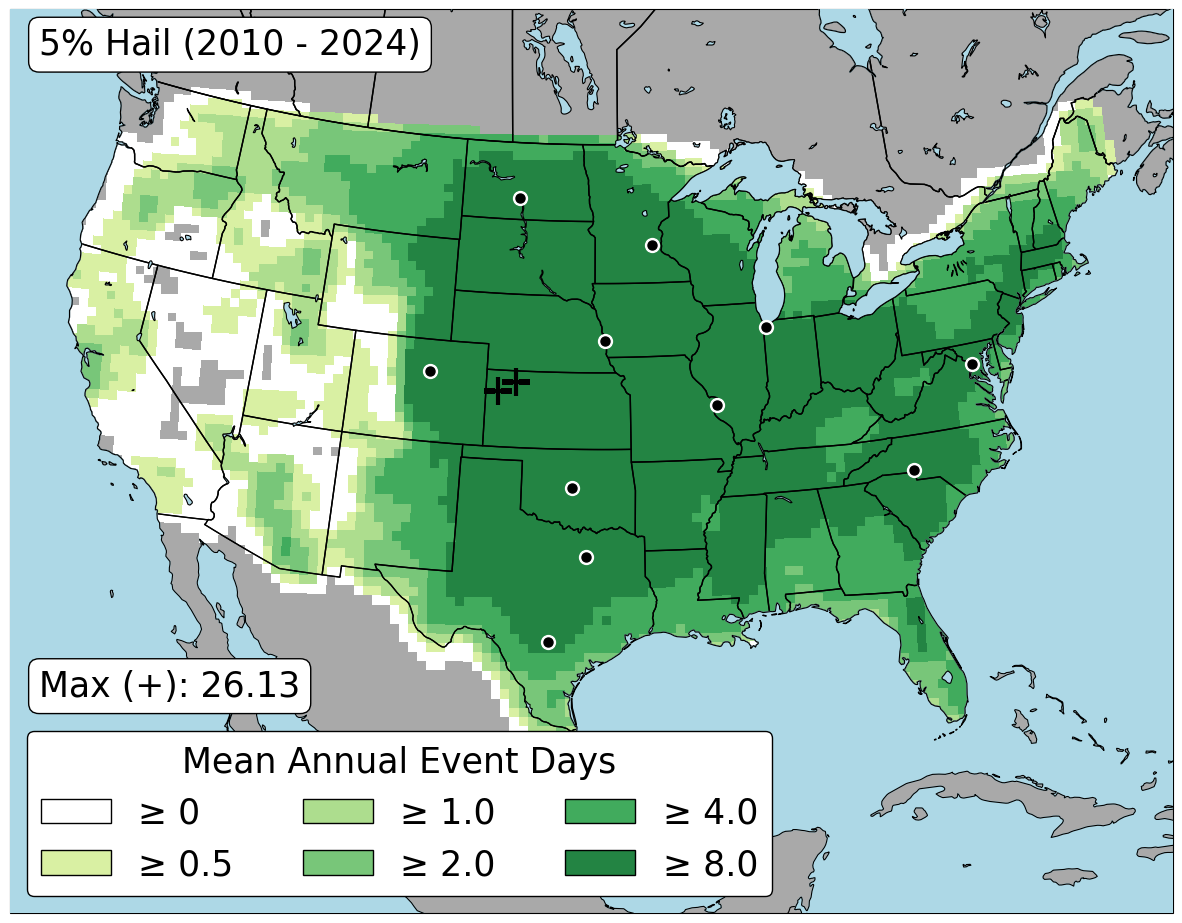

Processing hail at 10.0% severity...
Processed 5479 days for hail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 20.333 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs/hail_10pct_2010-2024.png


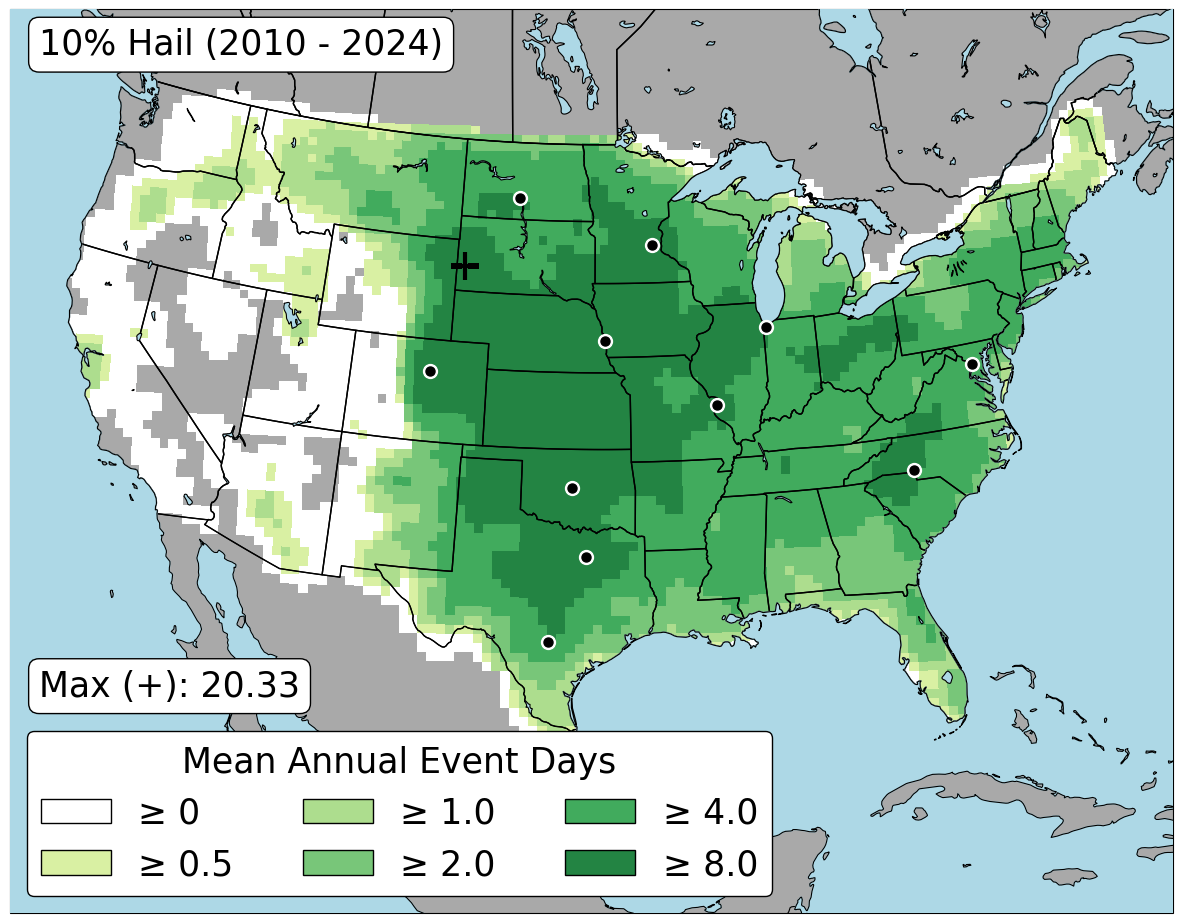

Processing hail at 15.0% severity...
Processed 5479 days for hail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 16.933 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs/hail_15pct_2010-2024.png


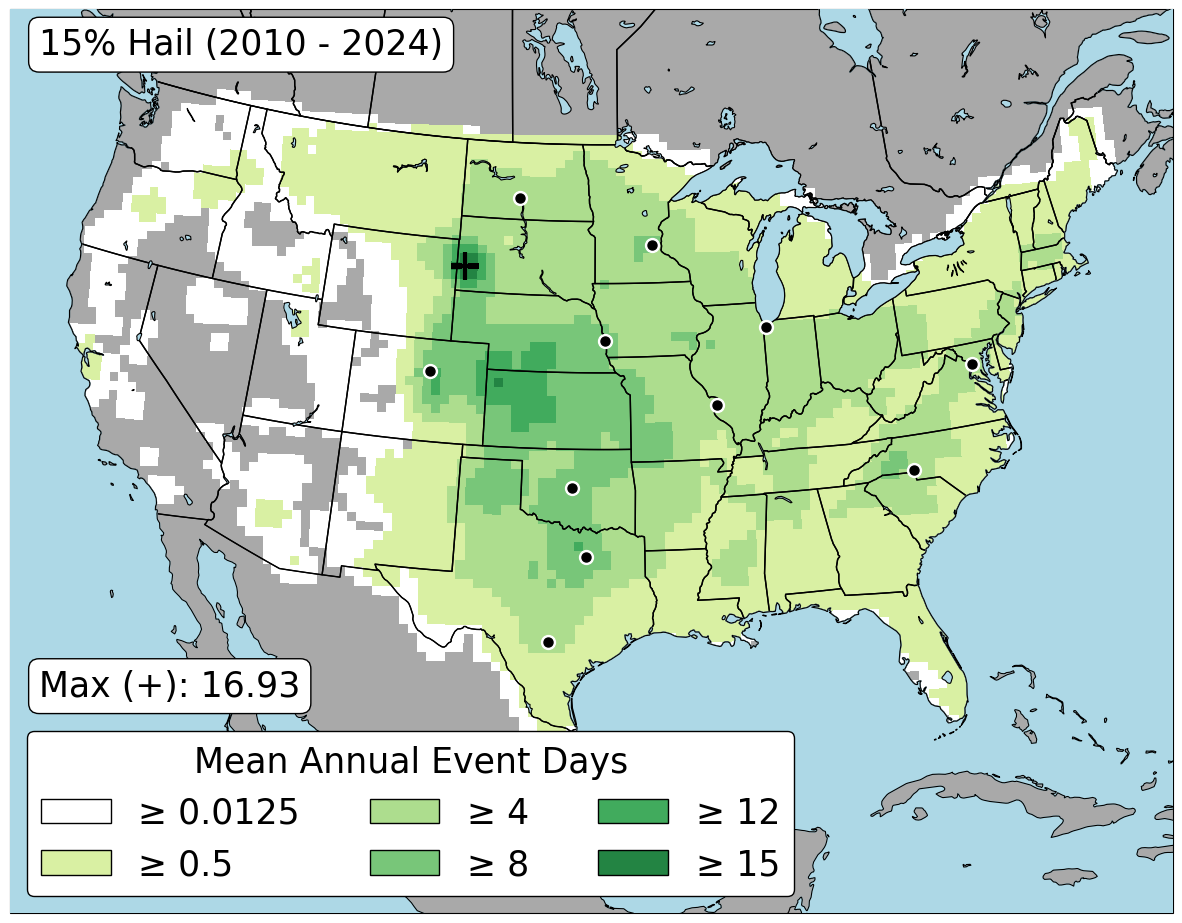

Processing hail at 30.0% severity...
Processed 5479 days for hail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 10.067 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs/hail_30pct_2010-2024.png


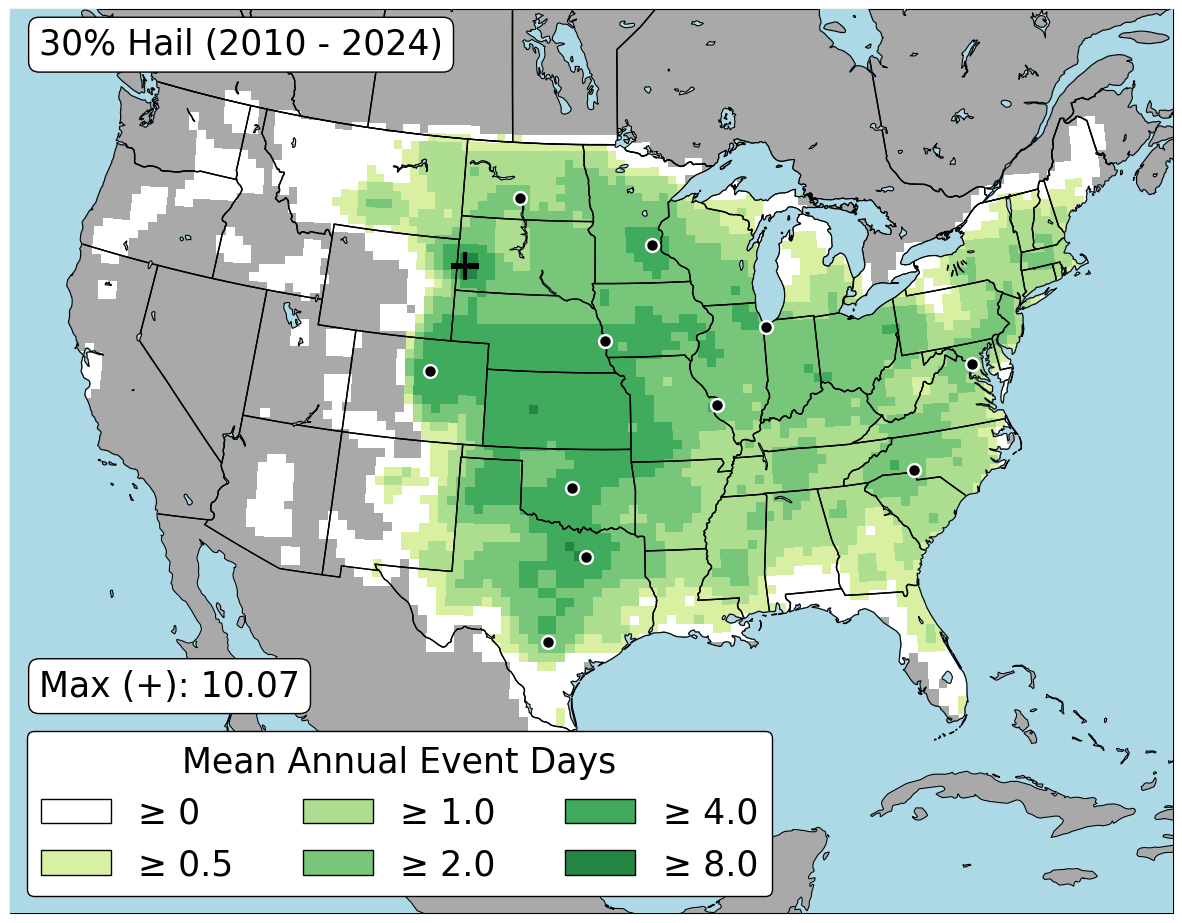

Processing hail at 60.0% severity...
Processed 5479 days for hail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 5.400 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs/hail_60pct_2010-2024.png


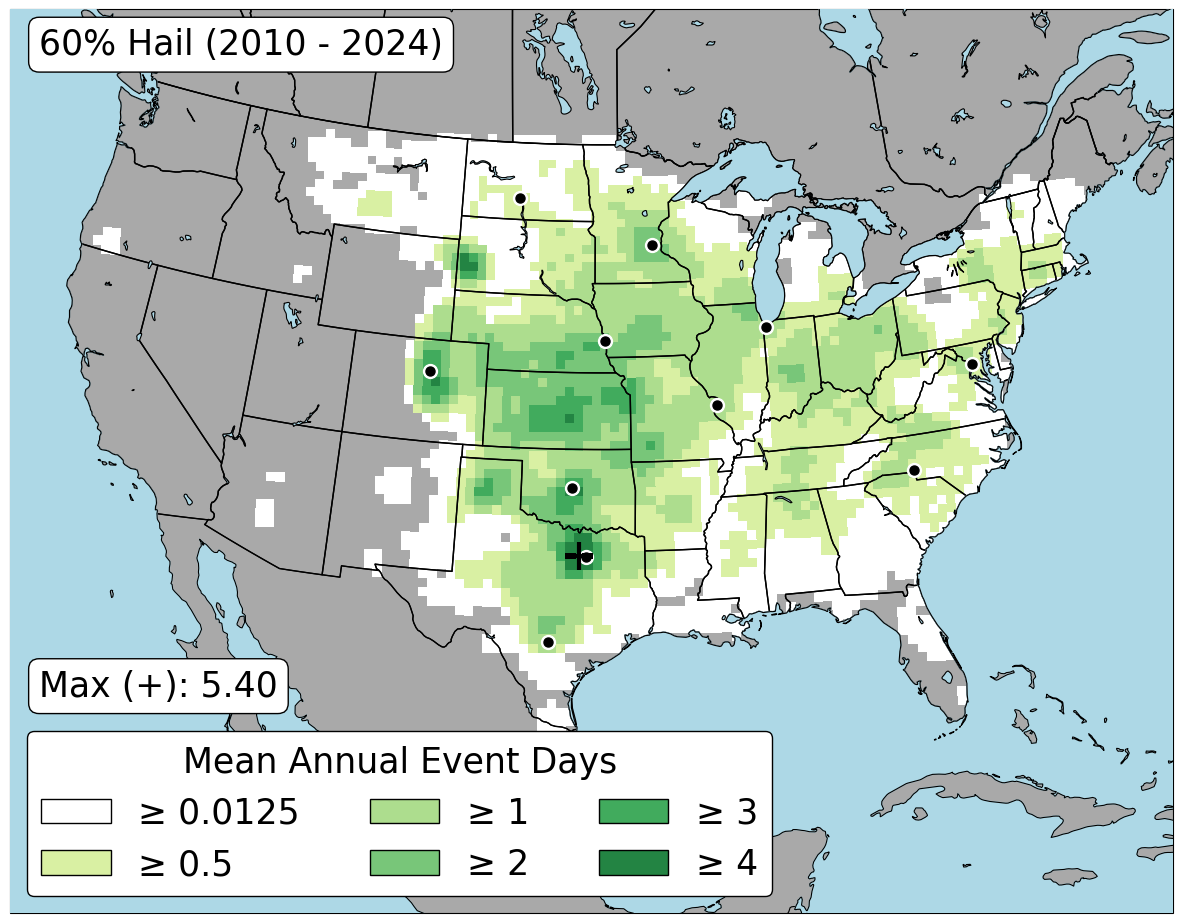

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

"Code graphs PPH for both noaa and ncei and attempts to replicate "
"Practically Perfect Hindcasts of Severe Convective Storms  visualizations"

"We use NCEI up until year 2024, and then 2025 onwards we use NOAA"

"All credit to the original research paper and its code can be found here"
url = 'https://github.com/ahaberlie/PPer_Climo'

"Before running, you must have adjusted the following "
"1) set the correct path for the grid spacing file (grid_ds)"
"2) Adjust file name for ncei_pph_namXXX output file in get_data_path function" 
"3) Adjust file name for noaa_pph_namXXX output file in get_data_path function"
"4) Adjust 'scales' in plot_pph_analysis function"

# Load your desired grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Years to analyze 
start_year = 2010 # Starts in January of this year
end_year = 2024 # Ends in December of this year

#Adjust file names to match your grid size
def get_data_path(storm_type, year, month, day):
    if year <= 2024:
        return f"/Users/jimnguyen/IRMII/SCS_API/PPH/NCEI_PPH/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"
    else:  # year >= 2025
        return f"noaa_pph_outputs/noaa_pph_nam212/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"

# Choose if "slight" or "moderate"
storm_configs = {
    'torn': [0.05, 0.10, 0.15, 0.30, 0.60],    # .05 = slight, .3 = moderate
    'wind': [0.05, 0.10, 0.15, 0.30, 0.60],    # .15 = slight, .6 = moderate
    'hail': [0.05, 0.10, 0.15, 0.30, 0.60]     # .15 = slight, .6 = moderate
}

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities plotted
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Dallas, TX': (-96.7977, 32.7815),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Minneapolis, MN': (-93.2650, 44.9778), 
        'Bismarck, ND': (-100.773703, 46.801942),
        'Chicago ,IL' : (-87.3954, 41.520480),
        'Washington, DC': (-77.0369, 38.9072)}

# Maps America
def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)

    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8,zorder=9)
    return ax

# Creates the key 
def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

# Visualizes the PPHs
def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask - values outside CONUS will be masked
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask both zero values AND values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines above the data
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Calculates the mean annual event days
def calculate_mean_annual_days(storm_type, severity, start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    days_processed = 0 
    total_days_above_threshold = None
    ncei_days = 0
    noaa_days = 0
    
    current_date = start_date 
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        day = current_date.day

        csv_path = get_data_path(storm_type, year, month, day)
        
        if not os.path.exists(csv_path):
            current_date += timedelta(days=1)
            continue

        try:
            df = pd.read_csv(csv_path)       
            pph_daily = (df.values >= severity).astype(int)

            if total_days_above_threshold is None:
                total_days_above_threshold = np.zeros_like(pph_daily)
            
            total_days_above_threshold += pph_daily
            days_processed += 1
            
            # Tracking if NCEI or NOAA
            if year <= 2024:
                ncei_days += 1
            else:
                noaa_days += 1
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
        current_date += timedelta(days=1)
    
    if days_processed == 0:
        print(f"No data found for {storm_type} from {start_year} to {end_year}")
        return None
        
    num_years = end_year - start_year + 1
    mean_annual_days = total_days_above_threshold / num_years
    print(f"Processed {days_processed} days for {storm_type}, {num_years} years")
    print(f"  - NCEI days: {ncei_days}")
    print(f"  - NOAA days: {noaa_days}")
    return mean_annual_days

# Main plotting function
def plot_pph_analysis(start_year, end_year, storm_configs):
    
    # Set up figure parameters
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Label positions
    plab_x = .025
    plab_y = .95
    maxlab_x = .025
    maxlab_y = .24
    
    # Color schemes and scales for each storm type
    color_schemes = {
        'torn': ['#ffffff','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000'],
        'hail': ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443'],  
        'wind': ['#ffffff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    }
    
    # Adjust scales depending on your grid type. 
    # Currently below is grid sizes for NAM212 40km 
    scales = {
        'torn': {
            0.05: [0.025, .5, 2, 3, 4, 5, 100],
            0.30: [0.0125, 0.15, .3, .45, .6, .75, 100]
        },
        'hail': {
            0.15:  [0.0125, .5, 4, 8, 12, 15, 100],
            0.60: [0.0125, .5, 1, 2, 3, 4, 100]

        },
        'wind': {
            0.15:  [0.025, 1, 3, 7, 12, 17, 100],
            0.60: [0.0125, .5, 1, 2, 2.5, 3, 100]
        }
    }

    storm_names = {
        'torn': 'Tornado',
        'hail': 'Hail', 
        'wind': 'Wind'
    }
    
    # Process each storm type
    for storm_type, severities in storm_configs.items():
        dy_colors = color_schemes[storm_type]
        
        for severity in severities:
            title = "Mean Annual Event Days"
            name = f"{severity*100:.0f}%"
            key = f'{name} {storm_names[storm_type]}'
            
            # Get appropriate scale
            if severity in scales[storm_type]:
                pper_scale = scales[storm_type][severity]
            else:
                # Fallback scale
                pper_scale = [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100]
            
            print(f"Processing {storm_type} at {severity*100}% severity...")
            data = calculate_mean_annual_days(storm_type, severity, start_year, end_year)
            
            if data is not None:
                dsub = xr.DataArray(data, dims=['y', 'x'])
                
                # Find maximum locations
                max_val = np.nanmax(dsub.values)
                y_max, x_max = np.where(dsub.values == max_val)
                
                print(f"Maximum value: {max_val:.3f} at {len(y_max)} locations")
                
                # Create the map
                fig = plt.figure(figsize=(15, 15))
                ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

                # Mark maximum locations
                for i in range(len(y_max)):
                    ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                           mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
                
                # Add cities with markers
                for city_name, city_loc in cities.items():
                    ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
                           transform=from_proj, zorder=10)
                    ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
                           transform=from_proj, zorder=10)
                    
                # Add text labels
                txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(start_year, end_year), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                
                txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.2f}".format(float(max_val)), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)


                filename = f"{storm_type}_{severity*100:.0f}pct_{start_year}-{end_year}.png"
                
                output_dir = f"/Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs"
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                else:
                    print("Output dir already exists")
                    
                filepath = os.path.join(output_dir, filename)
                
                plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                           facecolor='white', edgecolor='none')
            
                print(f"Saved: {filepath}")

                plt.show()
                
                plt.close()
                
            else:
                print(f"No data available for {storm_type} at {severity*100}% threshold")

# Run the analysis
if __name__ == "__main__":
    plot_pph_analysis(start_year, end_year, storm_configs)

# Calculate sighail PPH

In [39]:
"""
Generate PPH for annual NCEI_storm_reports
1200z Day1 to 1200z Day2 time windows
File names use Day1
    
MODIFIED: Now creates files with all zeros for dates with no events
MODIFIED: Accounts for BEGIN_DATE_TIME and END_DATE_TIME with 1200z-1200z periods
"""

import numpy as np
import os
import pandas as pd
import xarray as xr
import calendar
from datetime import datetime, timedelta

sigma_grid_units = 1.5
grid_spacing_km = 40.0   

# Download and Load NAM-212 grid 
url = 'https://github.com/ahaberlie/PPer_Climo/tree/master/data'
try:
    grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
    grid212_lat = grid_ds["gridlat_212"].values  # (ny, nx)
    grid212_lon = grid_ds["gridlon_212"].values  # (ny, nx)
    print(f"Loaded grid with shape: {grid212_lat.shape}")
except Exception as e:
    print(f"Error loading grid file: {e}")
    exit(1)

# Storm type mapping from EVENT_TYPE
storm_types = {
    "Hail": "sighail"
}

# Distance function for PPH
def euclidean_distance_km(grid_lat, grid_lon, report_lat, report_lon):
    lat_km = 111.32 * (grid_lat - report_lat)
    lon_km = 111.32 * np.cos(np.radians(report_lat)) * (grid_lon - report_lon)
    return np.sqrt(lat_km**2 + lon_km**2)

def parse_datetime_string(dt_string):
    """Parse datetime string to datetime object"""
    if pd.isna(dt_string) or dt_string == '' or dt_string is None:
        return None
    
    try:
        formats = [
            '%d-%b-%y %H:%M:%S',      # 01-APR-24 04:06:00 
        ]
        
        dt_string = str(dt_string).strip()
        
        # Try each format
        for i, fmt in enumerate(formats):
            try:
                parsed = datetime.strptime(dt_string, fmt)
                return parsed
            except ValueError:
                continue
        
        # If none of the formats work, try to parse with dateutil (more flexible)
        # Note: dateutil may not be available in all environments
        # try:
        #     from dateutil import parser
        #     return parser.parse(dt_string)
        # except:
        #     pass
        
        return None
        
    except Exception as e:
        return None

def event_overlaps_with_1200z_period(begin_dt, end_dt, period_year, period_month, period_day):
    """
    Check if an event (begin_dt to end_dt) overlaps with a 1200z-1200z period.
    Period runs from period_day 1200z to (period_day+1) 1200z.
    """
    if begin_dt is None:
        return False
    
    if end_dt is None:
        end_dt = begin_dt  # Assume instantaneous event if no end time
    
    try:
        # Create period boundaries
        period_start = datetime(period_year, period_month, period_day, 12, 0)  # 1200z Day1
        
        # Calculate next day for period end, handling month/year rollover
        next_day = period_start + timedelta(days=1)
        period_end = next_day.replace(hour=12, minute=0, second=0)  # 1200z Day2
        
        # Check for overlap: events overlap if event_start < period_end AND event_end > period_start
        overlaps = begin_dt < period_end and end_dt > period_start
        
        return overlaps
        
    except (ValueError, OverflowError):
        return False

# Create output directory
output_folder = "Sighail_PPH"
os.makedirs(output_folder, exist_ok=True)

# Create output subfolders for each storm type
for storm_type in storm_types.values():
    output_subfolder = os.path.join(output_folder, storm_type)
    os.makedirs(output_subfolder, exist_ok=True)

# Process each year from 2010-2024
for year in range(2010, 2025):  #2010 to 2024 inclusive
    file_path = f"/Users/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/sighail_filtered/Sighail_Reports_{year}.csv"
    
    # Initialize data as empty DataFrame in case file doesn't exist
    data = pd.DataFrame()
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path} - Will create zero files for all dates")
    else:
        try:
            print(f"\nProcessing {file_path}...")
            
            # Read the data
            data = pd.read_csv(file_path)
            
            # Clean and convert data types
            data['LAT'] = pd.to_numeric(data['LAT'], errors='coerce')
            data['LON'] = pd.to_numeric(data['LON'], errors='coerce')
            
            # Parse datetime strings
            data['BEGIN_DT'] = data['BEGIN_DATE_TIME'].apply(parse_datetime_string)
            data['END_DT'] = data['END_DATE_TIME'].apply(parse_datetime_string)
            
            # Debug datetime parsing
            parsed_count = data['BEGIN_DT'].notna().sum()
            print(f"  Successfully parsed datetimes: {parsed_count} / {len(data)}")
            
            if parsed_count == 0:
                print("  ERROR: NO DATETIMES PARSED SUCCESSFULLY!")
                print("  Sample datetime strings:", data['BEGIN_DATE_TIME'].head(3).tolist())
                continue  # Skip this year since datetime parsing completely failed
            
            # Remove rows with missing critical data
            initial_count = len(data)
            data = data.dropna(subset=['LAT', 'LON', 'BEGIN_DATE_TIME'])
            # Also remove rows where datetime parsing failed
            data = data[data['BEGIN_DT'].notna()]
            
            if len(data) < initial_count:
                print(f"  Removed {initial_count - len(data)} rows with missing/invalid data")

            # Filter to CONUS bounds
            conus_data = data[(data['LAT'] >= 24.52) & (data['LAT'] <= 49.385) &
                             (data['LON'] >= -124.74) & (data['LON'] <= -66.95)]

            if len(conus_data) < len(data):
                print(f"  Filtered {len(data) - len(conus_data)} reports outside CONUS")
            
            data = conus_data

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            data = pd.DataFrame()  # Use empty DataFrame if file read fails

    # Process each storm type
    for event_type, storm_type in storm_types.items():
        print(f"  Processing {event_type} reports for {year}...")
        
        # Filter data for this storm type (will be empty if no data loaded)
        if len(data) > 0:
            # Filter for hail events
            storm_data = data[data['EVENT_TYPE'] == event_type].copy() if 'EVENT_TYPE' in data.columns else data.copy()
            print(f"    Found {len(storm_data)} {event_type} reports")
        else:
            storm_data = pd.DataFrame()
            print(f"    No data available - creating zero files for all dates")
        
        # Get output subfolder for this storm type
        output_subfolder = os.path.join(output_folder, storm_type)
        
        # Process each month (always process all 12 months)
        for month in range(1, 13):
            # Determine number of days in this month
            days_in_month = calendar.monthrange(year, month)[1]
            
            # Process each day in the month (ALWAYS process all days)
            # Each day represents the start of a 1200z-1200z period
            for day in range(1, days_in_month + 1):
                
                # Find all events that overlap with this 1200z-1200z period
                period_events = []
                
                if len(storm_data) > 0:
                    for idx, row in storm_data.iterrows():
                        if event_overlaps_with_1200z_period(row['BEGIN_DT'], row['END_DT'], year, month, day):
                            period_events.append(row)
                
                # Convert to DataFrame
                if period_events:
                    day_data = pd.DataFrame(period_events)
                else:
                    day_data = pd.DataFrame()
                
                # Initialize the sum for PPH (always initialize, even for zero case)
                gaussian_sum = np.zeros_like(grid212_lat, dtype=np.float64)

                # Compute the PPH if there's data for this period
                if len(day_data) > 0:
                    for _, row in day_data.iterrows():
                        d_km = euclidean_distance_km(
                            grid212_lat, grid212_lon,
                            row['LAT'], row['LON']
                        )
                        
                        # Convert to grid units 
                        d_grid = d_km / grid_spacing_km
                        
                        # Summing the Nth terms 
                        gaussian_sum += np.exp(-0.5 * (d_grid / sigma_grid_units) ** 2)
                    
                    print(f"    Calculated PPH for {storm_type} period {year}-{month:02d}-{day:02d} 1200z to {year}-{month:02d}-{day+1:02d} 1200z ({len(day_data)} reports)")
                else:
                    print(f"    Created zero PPH for {storm_type} period {year}-{month:02d}-{day:02d} 1200z to next day 1200z (0 reports)")

                # Apply prefactor: (1 / (2π σ²)) - this will result in zeros if gaussian_sum is all zeros
                gauss_pref = 1.0 / (2.0 * np.pi * sigma_grid_units**2)
                daily_pph = gauss_pref * gaussian_sum
                rounded_pph = np.round(daily_pph, 10)

                # Saving (ALWAYS save, even if all zeros)
                # File name uses Day1 of the period
                file_name_out = f"pph_{year}_{month:02d}_{day:02d}.csv"
                output_file = os.path.join(output_subfolder, file_name_out)

                try:
                    df = pd.DataFrame(rounded_pph)
                    df.to_csv(output_file, index=False)
                    
                except Exception as e:
                    print(f"    Error saving PPH for {year}-{month:02d}-{day:02d}: {e}")
                    continue

print("\nPPH processing complete!")

Loaded grid with shape: (129, 185)

Processing /Users/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/sighail_filtered/Sighail_Reports_2010.csv...
  Successfully parsed datetimes: 663 / 663
  Processing Hail reports for 2010...
    Found 663 Hail reports
    Created zero PPH for sighail period 2010-01-01 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-02 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-03 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-04 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-05 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-06 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-07 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-08 1200z to next day 1200z (0 reports)
    Created zero PPH for sighail period 2010-01-09 120

# Graph sighail PPH

Processing sighail at 5.0% severity...
Processed 5479 days for sighail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 0.000 at 23865 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_5pct_2010-2024.png


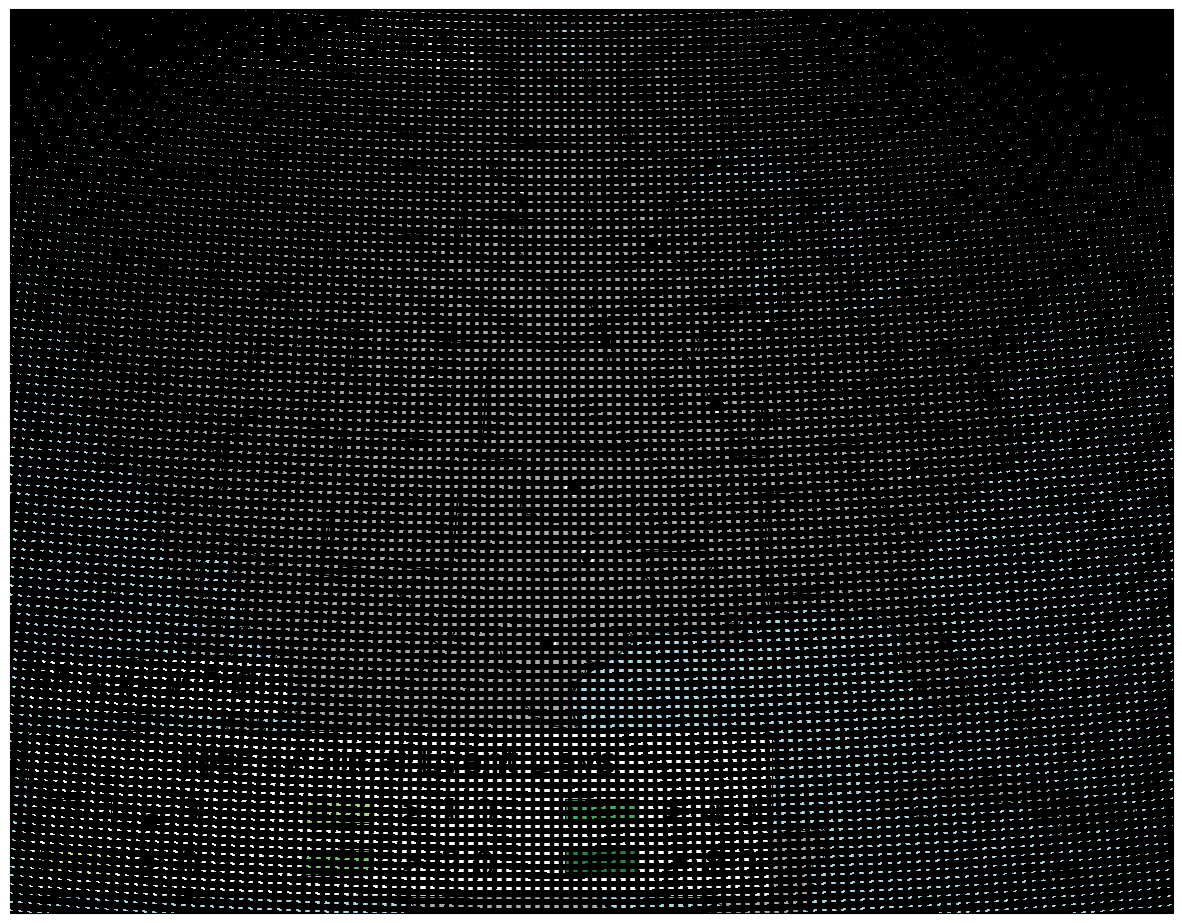

Processing sighail at 10.0% severity...
Processed 5479 days for sighail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 0.000 at 23865 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_10pct_2010-2024.png


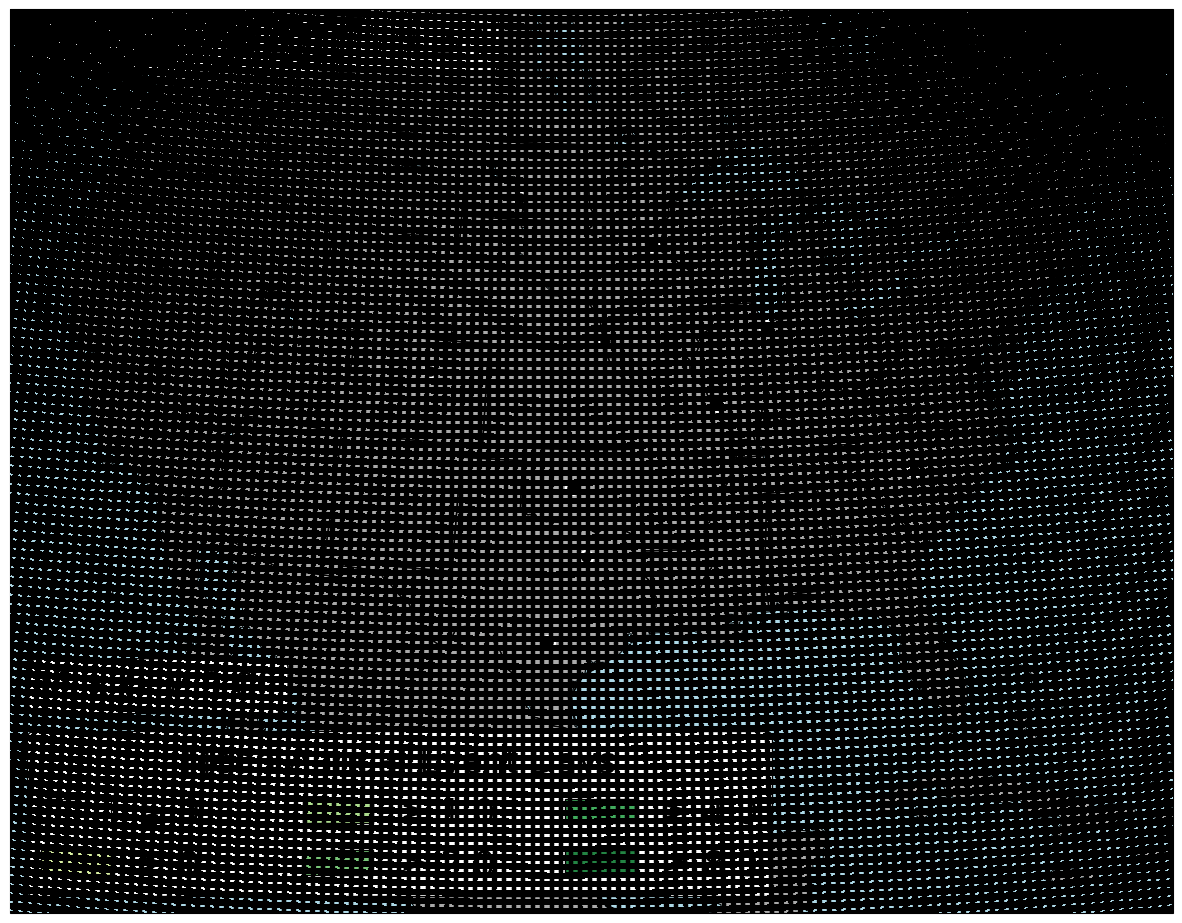

Processing sighail at 15.0% severity...
Processed 5479 days for sighail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 0.000 at 23865 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_15pct_2010-2024.png


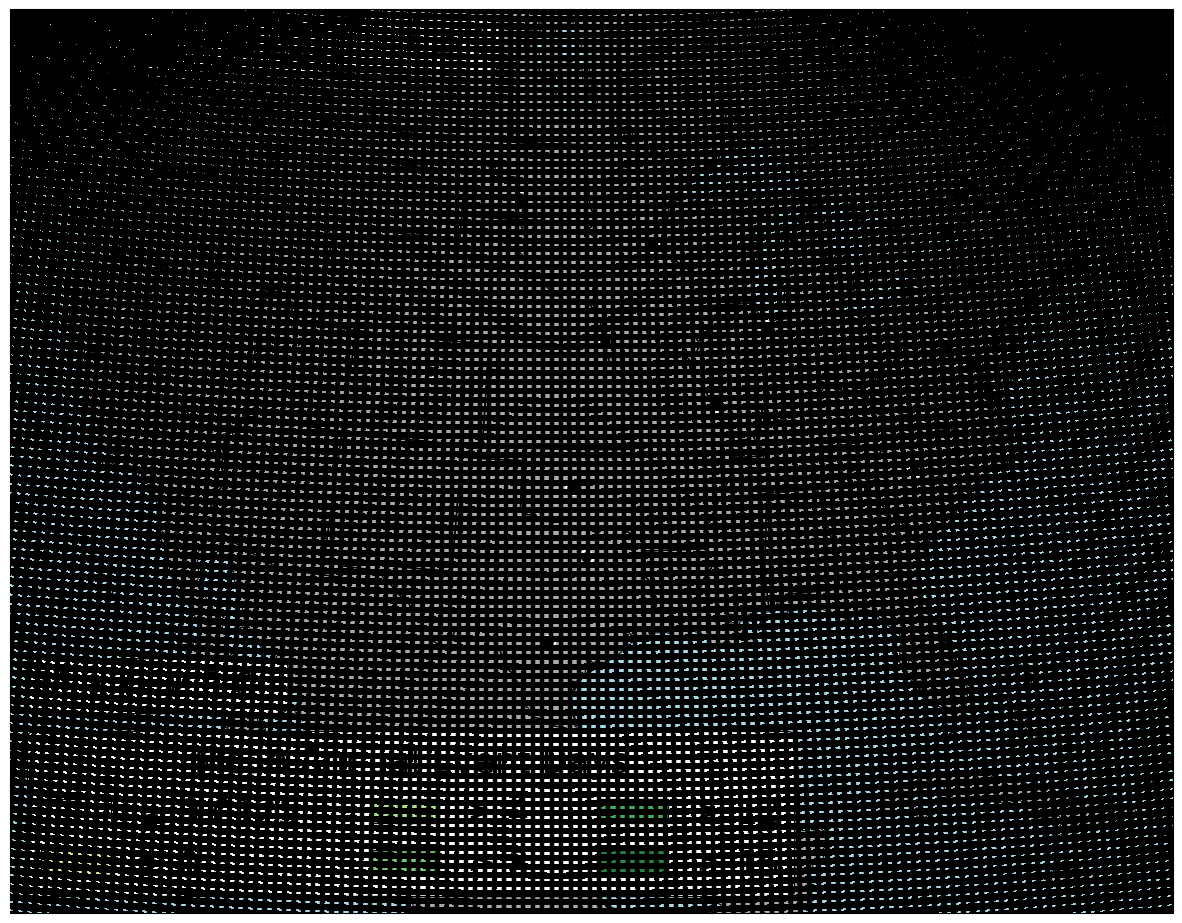

Processing sighail at 30.0% severity...
Processed 5479 days for sighail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 0.000 at 23865 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_30pct_2010-2024.png


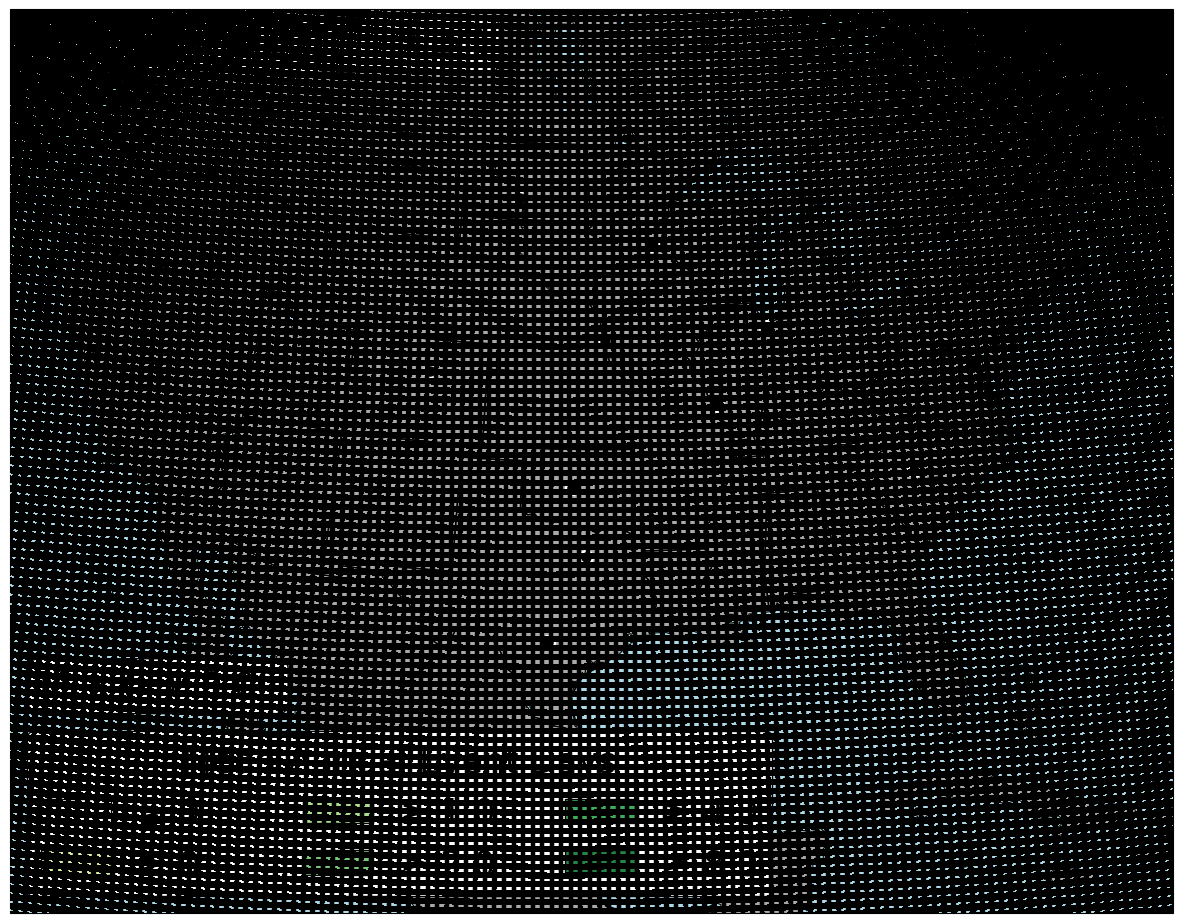

Processing sighail at 60.0% severity...
Processed 5479 days for sighail, 15 years
  - NCEI days: 5479
  - NOAA days: 0
Maximum value: 0.000 at 23865 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_60pct_2010-2024.png


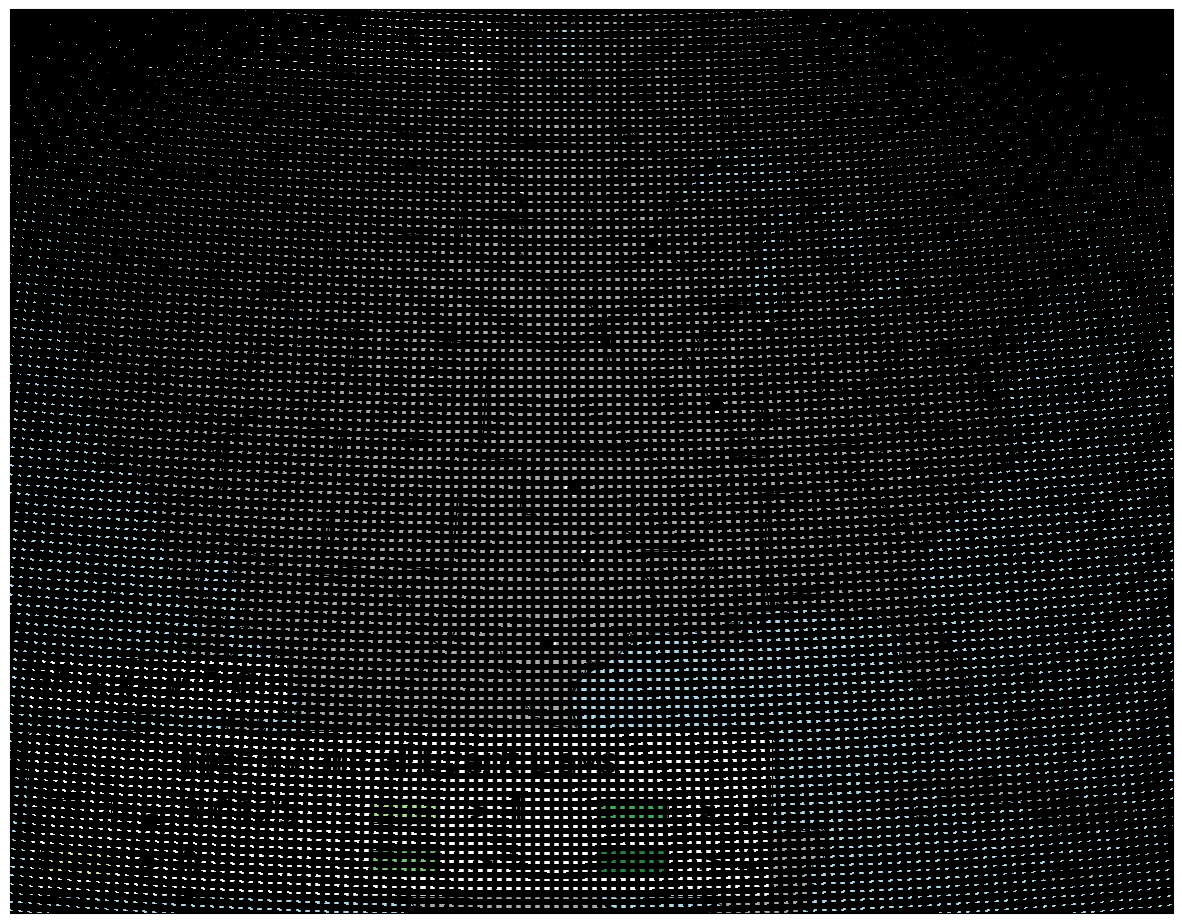

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

"Code graphs PPH for both noaa and ncei and attempts to replicate "
"Practically Perfect Hindcasts of Severe Convective Storms  visualizations"

"We use NCEI up until year 2024, and then 2025 onwards we use NOAA"

"All credit to the original research paper and its code can be found here"
url = 'https://github.com/ahaberlie/PPer_Climo'

"Before running, you must have adjusted the following "
"1) set the correct path for the grid spacing file (grid_ds)"
"2) Adjust file name for ncei_pph_namXXX output file in get_data_path function" 
"3) Adjust file name for noaa_pph_namXXX output file in get_data_path function"
"4) Adjust 'scales' in plot_pph_analysis function"

# Load your desired grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Years to analyze 
start_year = 2010 # Starts in January of this year
end_year = 2024 # Ends in December of this year

#Adjust file names to match your grid size
def get_data_path(storm_type, year, month, day):
    if year <= 2024:
        return f"/Users/jimnguyen/IRMII/SCS_API/PPH/Sighail_PPH/sighail/pph_{year}_{month:02d}_{day:02d}.csv"
    else:  # year >= 2025
        return f"noaa_pph_outputs/noaa_pph_nam212/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"

# Choose if "slight" or "moderate"
storm_configs = {
    'sighail': [0.10]
    #'sighail': [0.05, 0.10, 0.15, 0.30, 0.60]     # .15 = slight, .6 = moderate

}

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities plotted
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Dallas, TX': (-96.7977, 32.7815),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Minneapolis, MN': (-93.2650, 44.9778), 
        'Bismarck, ND': (-100.773703, 46.801942),
        'Chicago ,IL' : (-87.3954, 41.520480),
        'Washington, DC': (-77.0369, 38.9072)}

# Maps America
def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)

    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8,zorder=9)
    return ax

# Creates the key 
def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

# Visualizes the PPHs
def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask - values outside CONUS will be masked
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask both zero values AND values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines above the data
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Calculates the mean annual event days
def calculate_mean_annual_days(storm_type, severity, start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    days_processed = 0 
    total_days_above_threshold = None
    ncei_days = 0
    noaa_days = 0
    
    current_date = start_date 
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        day = current_date.day

        csv_path = get_data_path(storm_type, year, month, day)
        
        if not os.path.exists(csv_path):
            current_date += timedelta(days=1)
            continue

        try:
            df = pd.read_csv(csv_path)       
            pph_daily = (df.values >= severity).astype(int)

            if total_days_above_threshold is None:
                total_days_above_threshold = np.zeros_like(pph_daily)
            
            total_days_above_threshold += pph_daily
            days_processed += 1
            
            # Tracking if NCEI or NOAA
            if year <= 2024:
                ncei_days += 1
            else:
                noaa_days += 1
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
        current_date += timedelta(days=1)
    
    if days_processed == 0:
        print(f"No data found for {storm_type} from {start_year} to {end_year}")
        return None
        
    num_years = end_year - start_year + 1
    mean_annual_days = total_days_above_threshold / num_years
    print(f"Processed {days_processed} days for {storm_type}, {num_years} years")
    print(f"  - NCEI days: {ncei_days}")
    print(f"  - NOAA days: {noaa_days}")
    return mean_annual_days

# Main plotting function
def plot_pph_analysis(start_year, end_year, storm_configs):
    
    # Set up figure parameters
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Label positions
    plab_x = .025
    plab_y = .95
    maxlab_x = .025
    maxlab_y = .24
    
    # Color schemes and scales for each storm type
    color_schemes = {
        'sighail': ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443'],  
    }
    
    # Adjust scales depending on your grid type. 
    # Currently below is grid sizes for NAM212 40km 
    scales = {
        'sighail': {
            0.15:  [0.0125, .5, 4, 8, 12, 15, 100],
            0.60: [0.0125, .5, 1, 2, 3, 4, 100]

        },
    }

    storm_names = {
        'sighail': 'sighail', 
    }
    
    # Process each storm type
    for storm_type, severities in storm_configs.items():
        dy_colors = color_schemes[storm_type]
        
        for severity in severities:
            title = "Mean Annual Event Days"
            name = f"{severity*100:.0f}%"
            key = f'{name} {storm_names[storm_type]}'
            
            # Get appropriate scale
            if severity in scales[storm_type]:
                pper_scale = scales[storm_type][severity]
            else:
                # Fallback scale
                pper_scale = [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100]
            
            print(f"Processing {storm_type} at {severity*100}% severity...")
            data = calculate_mean_annual_days(storm_type, severity, start_year, end_year)
            
            if data is not None:
                dsub = xr.DataArray(data, dims=['y', 'x'])
                
                # Find maximum locations
                max_val = np.nanmax(dsub.values)
                y_max, x_max = np.where(dsub.values == max_val)
                
                print(f"Maximum value: {max_val:.3f} at {len(y_max)} locations")
                
                # Create the map
                fig = plt.figure(figsize=(15, 15))
                ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

                # Mark maximum locations
                for i in range(len(y_max)):
                    ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                           mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
                
                # Add cities with markers
                for city_name, city_loc in cities.items():
                    ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
                           transform=from_proj, zorder=10)
                    ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
                           transform=from_proj, zorder=10)
                    
                # Add text labels
                txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(start_year, end_year), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                
                txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.2f}".format(float(max_val)), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)


                filename = f"{storm_type}_{severity*100:.0f}pct_{start_year}-{end_year}.png"
                
                output_dir = f"/Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs"
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                else:
                    print("Output dir already exists")
                    
                filepath = os.path.join(output_dir, filename)
                
                plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                           facecolor='white', edgecolor='none')
            
                print(f"Saved: {filepath}")

                plt.show()
                
                plt.close()
                
            else:
                print(f"No data available for {storm_type} at {severity*100}% threshold")

# Run the analysis
if __name__ == "__main__":
    plot_pph_analysis(start_year, end_year, storm_configs)

In [7]:
"""
Get PPH graphs for individual years
"""

'\nGet PPH graphs for individual years\n'

Loading PPH data for May 19th, 2023...
Data shape: (129, 185)
Max PPH value: 1.225728
Min PPH value: 0.000000
Non-zero values: 1453
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Individual_Day_Graphs/hail_pph_2023_05_19.png
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Individual_Day_Graphs/hail_pph_2023_05_19.png


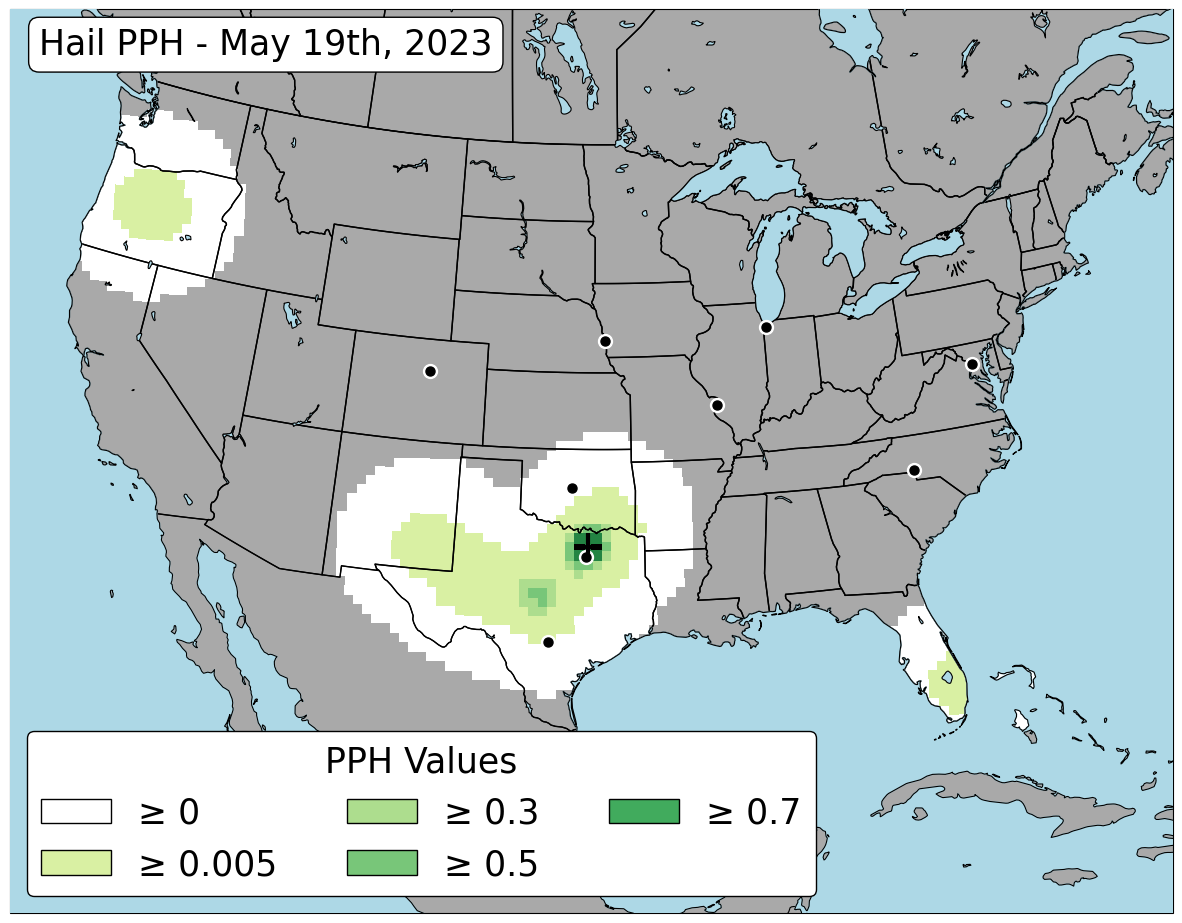

In [ ]:
"""
Graph PPH for May 19th, 2023 specifically
"""

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

# Load NAM-212 grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc")
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities to plot
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Dallas, TX': (-96.7977, 32.7815),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Chicago, IL': (-87.3954, 41.520480),
        'Washington, DC': (-77.0369, 38.9072)}

def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8, zorder=9)
    return ax

def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    return ax

def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask zero values and values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    return ax

# Load May 19th, 2023 PPH data for hail
date_str = "2023_05_19"
csv_path = f"/Users/jimnguyen/IRMII/SCS_API/PPH/NCEI_PPH/hail/pph_2023_05_19.csv"

print(f"Loading PPH data for May 19th, 2023...")

if os.path.exists(csv_path):
    # Load the PPH data
    df = pd.read_csv(csv_path)
    pph_data = df.values
    
    print(f"Data shape: {pph_data.shape}")
    print(f"Max PPH value: {np.max(pph_data):.6f}")
    print(f"Min PPH value: {np.min(pph_data):.6f}")
    print(f"Non-zero values: {np.count_nonzero(pph_data)}")
    
    # Convert to xarray DataArray
    dsub = xr.DataArray(pph_data, dims=['y', 'x'])
    
    # Color scheme for hail
    hail_colors = ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443']
    
    # Scale for the PPH values - adjust based on the data range
    max_val = np.max(pph_data)
    pph_scale = [0, 0.005, 0.3, 0.5, 0.7,100]

    # Set up figure
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Create the map
    fig = plt.figure(figsize=(15, 15))
    ax = draw_pper_map(dsub, "PPH Values", pph_scale, hail_colors)
    
    # Find and mark maximum locations
    if max_val > 0:
        y_max, x_max = np.where(pph_data == max_val)
        for i in range(len(y_max)):
            ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                   mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
    
    # Add cities
    for city_name, city_loc in cities.items():
        ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
               transform=from_proj, zorder=10)
        ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
               transform=from_proj, zorder=10)
    
    # Add text labels
    title_text = f"Hail PPH - May 19th, 2023"
    ax.text(0.025, 0.95, title_text, 
            transform=ax.transAxes, fontsize=25, 
            bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    
    # Save the figure
    output_dir = "/Users/jimnguyen/IRMII/SCS_API/PPH/Individual_Day_Graphs"
    os.makedirs(output_dir, exist_ok=True)
    
    filename = f"hail_pph_2023_05_19.png"
    filepath = os.path.join(output_dir, filename)
    
    plt.savefig(filepath, dpi=300, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    print(f"Saved: {filepath}")
    
    plt.show()
    
else:
    print(f"PPH file not found: {csv_path}")
    print("Please ensure the PPH data has been generated for May 19th, 2023")